# Import

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import algorithm
import datasets

from sklearn.linear_model import LogisticRegression as ScikitLogisticRegression
from sklearn.datasets import load_iris
from sklearn import metrics

# Logistic Regression Implementation

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogisticRegression(algorithm.BinaryClassifier):
    """
    Logistic Regression with l2 regularization, Newton Raphson optimization
    """
    def __init__(self, threshold=0.5, 
                 niter_max=1000, 
                 newton_eps=1e-2, 
                 regularization=1,
                optimization = "newton"):
        """
        newton_eps: stopping criterion
        """
        super().__init__(threshold=threshold)
        self.w = None
        self.niter_max = niter_max
        self.newton_eps = newton_eps
        self.regularization = regularization
        self.optimization = optimization
        self.alpha_grad_descent = 0.01
    
    def loss(self):
        """
        Cross entropy loss
        """
        pred = sigmoid(self.X_train.dot(self.w))
        pred[pred == 0] = 1e-5
        pred[pred == 1] = 1 - 1e-5
        regularization = self.regularization*0.5*self.w[:-1].dot(self.w[:-1])
        E = self.y_train.dot(np.log(pred)) + (1-self.y_train).dot(np.log(1-pred)) + regularization
        return -E
    
    def compute_R_w(self):
        diag_el = sigmoid(self.X_train.dot(self.w))*(1-sigmoid(self.X_train.dot(self.w)))
        R_w = np.diag(diag_el)
        return R_w
    
    def initialize(self, X_train, y_train):
        super().initialize(X_train, y_train, add_intercept=True)
        self.w = np.zeros(self.d)
        
    def fit(self, X_train, y_train):
        self.initialize(X_train, y_train)
        
        self.w = np.zeros(self.d)
        w_prev = np.inf*np.ones((self.d,))
        R_w = self.compute_R_w()
        
        i = 0
        while i < self.niter_max and max(np.abs(w_prev-self.w)) > self.newton_eps:
            w_prev = self.w 
            
            
            
            Xw = self.X_train.dot(self.w)
            
            regularization_grad = self.regularization*self.w
            regularization_grad[-1] = 0 # do not regularize the intercept
            grad = self.X_train.T.dot(sigmoid(Xw)-self.y_train) + regularization_grad
            
            if "newton" in self.optimization :
                regularization_H = self.regularization*np.eye(self.d)
                regularization_H[-1,-1] = 0 # do not regularize the intercept
                H = self.X_train.T.dot(R_w).dot(self.X_train) + regularization_H
                self.w = self.w - np.linalg.inv(H).dot(grad)
            elif "gradient" in self.optimization:
                self.w = self.w - self.alpha_grad_descent*(grad)
                if i > self.niter_max - 20:
                    self.alpha_grad_descent /=2
            R_w = self.compute_R_w()
            
            
            i += 1
        print("Loss = ", self.loss(), ", weights norm = ", self.w.T.dot(self.w), "N Newton steps = ", i)
        
    def predict_proba(self, X_test):
        X_test = np.hstack((X_test,np.ones((X_test.shape[0],1))))
        return sigmoid(X_test.dot(self.w))
    
    def predict_class(self, X_test):
        return self.predict_proba(X_test) > self.threshold
    
    
    def visualize(self, X_test, n_points=200):
        x_min = np.min(X_test[:,0])
        x_max = np.max(X_test[:,0])
        
        y_min = np.min(X_test[:,1])
        y_max = np.max(X_test[:,1])
        
        x1 = np.linspace(x_min, x_max, n_points)
        x2 = (-lr.w[2]-lr.w[0]*x1)/lr.w[1]
        ok_idx = (y_min <= x2) & (x2 <= y_max)
        
        plt.plot(x1[ok_idx],x2[ok_idx],"k--", label="decision boundary")

# 2D synthetic dataset

## Linearly separable

In [3]:
dummy = datasets.DummyDataset2D(means = [[30,40], [38,48]], N=200, )
X,y = dummy.generate()

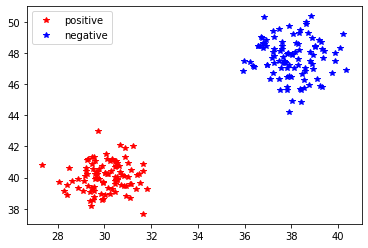

In [4]:
dummy.plot()

### No regularization

In [5]:
# No regularization:
# Sometimes H is just singular
lr = LogisticRegression(newton_eps=1e-5, regularization=0, niter_max=1000, optimization="newton")

lr.fit(X,y)


Loss =  0.0010000050000287825 , weights norm =  928303.1789442932 N Newton steps =  1000


In [6]:
# Can use gradient descent instead
lr = LogisticRegression(newton_eps=1e-5, regularization=0, niter_max=10000, optimization="gradient_descent")

lr.fit(X,y)


/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Loss =  5323.064260133808 , weights norm =  1069922.369102333 N Newton steps =  9997


no regularization => weights can be very large

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


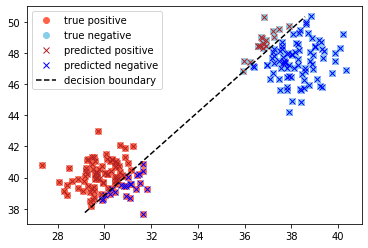

In [7]:
lr.plot_2D(X,y)

###  Regularization

In [8]:
# Beware of not regularizing the intercept...
lr = LogisticRegression(newton_eps=1e-5, regularization=1, niter_max=100, optimization="newton")

lr.fit(X,y)


Loss =  -0.5457680439731456 , weights norm =  4947.556044623231 N Newton steps =  10


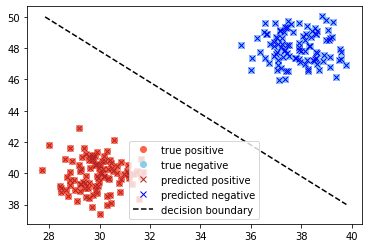

In [9]:
lr.plot_2D(X,y)

## Robustness to outliers

In [10]:
dummy = datasets.DummyDataset2D(means = [[30,40], [33,43]], N=200, )
dummy.generate();
dummy.add_rnd_normal(mean=[20,20], n=5)

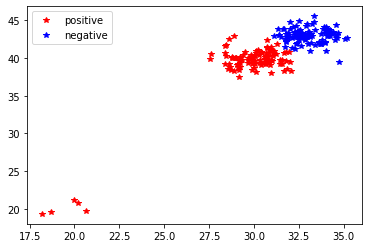

In [11]:
dummy.plot()

Loss =  1.5277877112238718 , weights norm =  24671.993499253156 N Newton steps =  10


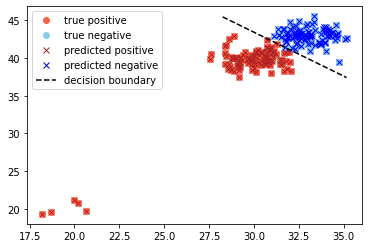

In [12]:
X,y = dummy.X, dummy.y
lr = LogisticRegression(newton_eps=1e-5, regularization=1, niter_max=100, optimization="newton")

lr.fit(X,y)
lr.plot_2D(X,y)

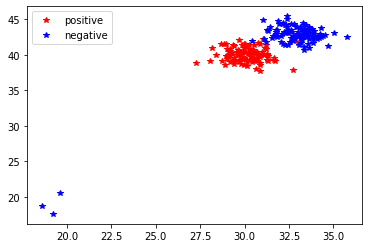

In [13]:
dummy = datasets.DummyDataset2D(means = [[30,40], [33,43]], N=200, )
dummy.generate();
dummy.add_rnd_normal(mean=[20,20], n=3, positive=0)
dummy.plot()

Loss =  94.06388373320567 , weights norm =  1028.4164762643873 N Newton steps =  6


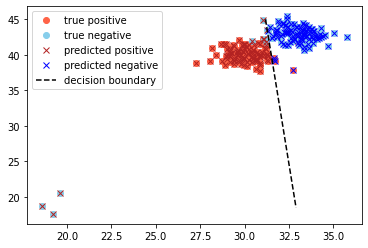

In [14]:
X,y = dummy.X, dummy.y
lr = LogisticRegression(newton_eps=1e-5, regularization=1, niter_max=100, optimization="newton")

lr.fit(X,y)
lr.plot_2D(X,y)

Loss =  94.22075353248 , weights norm =  386.09539784055494 N Newton steps =  5


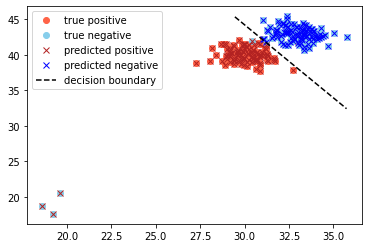

In [15]:
X,y = dummy.X, dummy.y
lr = LogisticRegression(newton_eps=1e-5, regularization=100, niter_max=100, optimization="newton")

lr.fit(X,y)
lr.plot_2D(X,y)

# MNIST dataset

## Raw

In [16]:
digit_dataset = datasets.Digits()

In [17]:
X_train, X_test, y_train, y_test = digit_dataset.generate_train_test(digits=[0,1]);

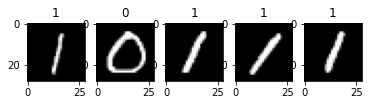

In [18]:
digit_dataset.display_digits()

In [19]:
lr = LogisticRegression(newton_eps=1e-5, regularization=1, niter_max=100, optimization="newton")

lr.fit(X_train[:1000],y_train[:1000])


Loss =  -0.0005627843289410159 , weights norm =  9.58761569086268 N Newton steps =  22


In [20]:
lr.evaluate(X_train,y_train)

(0.9990277102576568, 0.9993866911990187, 0.9987741342323015)

In [21]:
lr.evaluate(X_test, y_test)

(0.9996219281663516, 1.0, 0.9992962702322308)

In [22]:

lr_scikit = ScikitLogisticRegression()

lr_scikit.fit(X_train,y_train)

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
lr_scikit.score(X_train,y_train)

1.0

In [17]:
lr_scikit.score(X_test,y_test)

0.9996219281663516

In [21]:
scikit_pred = lr_scikit.predict(X_test)

In [23]:
metrics.confusion_matrix(y_true=y_test,y_pred=scikit_pred)

array([[1244,    1],
       [   0, 1400]])

## Significant features

In [24]:
std_train = np.std(X_train, axis=0)

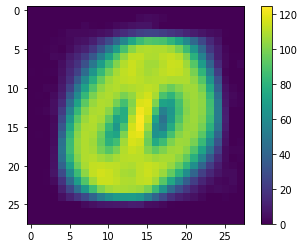

In [28]:
plt.imshow(std_train.reshape((28,28)))
plt.colorbar()

In [29]:
significant_pixels = std_train >100

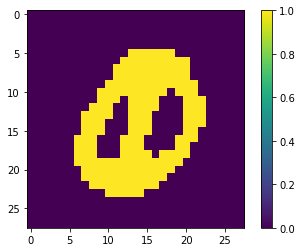

In [34]:
std_significant = std_train
std_significant[~significant_pixels] = 0
std_significant[significant_pixels] = 1
plt.imshow(std_significant.reshape((28,28)))
plt.colorbar()

In [36]:
# Drop unsignificant pixels
significant_X_train = X_train[:,significant_pixels]
significant_X_test = X_test[:,significant_pixels]

In [37]:
significant_X_train.shape

(6171, 185)

In [65]:
lr = LogisticRegression(newton_eps=1e-3, regularization=1, niter_max=100, optimization="newton")
lr.fit(significant_X_train,y_train)

Loss =  0.015322672355827436 , weights norm =  372.77302253802446 N Newton steps =  24


In [66]:
lr.evaluate(significant_X_test, y_test)

(0.998109640831758, 0.9978586723768736, 0.9985714285714286)

In [43]:
lr_scikit = ScikitLogisticRegression()

lr_scikit.fit(significant_X_train,y_train)
lr_scikit.score(significant_X_train,y_train)

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

In [44]:
lr_scikit.score(significant_X_test,y_test)

0.9973534971644612

In [45]:
w_scikit=  lr_scikit.coef_

In [47]:
w_scikit.dot(w_scikit.T)

array([[0.00290798]])